## Importando as bibliotecas

In [2]:
import msgpack
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from collections import OrderedDict

from geexhp.pypsg import PSG
import geexhp.util.mod as mod

import matplotlib.pyplot as plt

plt.rcParams.update({
            "axes.spines.right": False,
            "axes.spines.top": False,
            "font.size": 12,
            "axes.labelsize": 12,
            "axes.titlesize": 12,
            "legend.fontsize": 10,
            "xtick.labelsize": 10,
            "ytick.labelsize": 10,
            "figure.figsize" : (10, 4)
            })

## Primeiro Teste - Carregando arquivo de configuração do HWO para Terra moderna

In [3]:
with open("../geexhp/config/default_habex.config", "rb") as f:
    config = OrderedDict(msgpack.unpack(f, raw=False))

In [4]:
psg = PSG(server_url= "http://127.0.0.1:3000/api.php", timeout_seconds = 200)

Testing connection to PSG at http://127.0.0.1:3000/api.php ...
Connected to PSG with success.


In [5]:
config_HWC = config.copy()
mod.instrumento(config_HWC, instrumento='HWC')
resultado = psg.run(config_HWC)

In [5]:
print(resultado["header"])

# ------------------------------------------------------------------------
# Radiance spectrum
# NASA-GSFC Planetary Spectrum Generator (PSG) (Villanueva et al. 2018, 2022)
# Synthesized on Wed Apr 24 22:33:53 2024
# Doppler velocities [km/s] (vobs,vrot+vorb,vwidth,vrfl,vstr): 0.00000,0.00000,0.00000,0.00000,-0.00000
# ------------------------------------------------------------------------
# Spectra synthesized with the Planetary and Universal Model of Atmospheric Scattering (PUMAS, Villanueva et al. 2018, 2022)
# Multiple scattering method employing PSGDORT, NMAX:1 / LMAX:2 / gMAX:0.00
# ------------------------------------------------------------------------
# Spectral unit: Wavelength [um]
# Radiance unit: I/F [apparent albedo]
# Wave/freq Total Noise Exoplanet


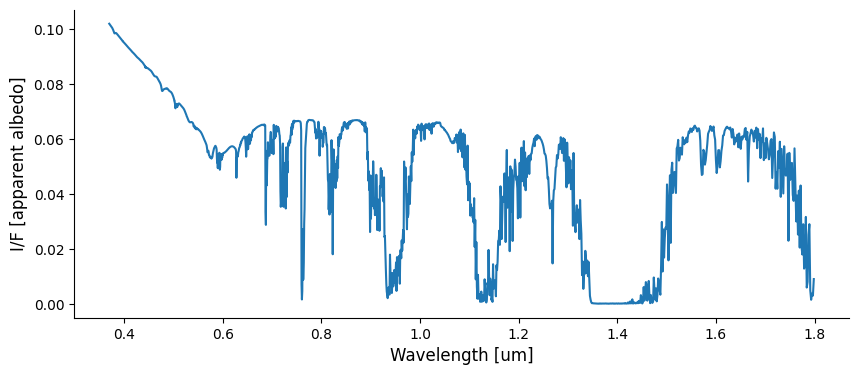

In [6]:
colunas = ["Wave/freq", "Total", "Noise", "Exoplanet"]
df = pd.DataFrame(resultado["spectrum"], columns=colunas)

_, ax = plt.subplots()
ax.plot(df["Wave/freq"], df["Total"])
ax.set(xlabel="Wavelength [um]", ylabel="I/F [apparent albedo]");

In [7]:
def test_instrumento(config, instrumento):
    mod.instrumento(config, instrumento)
    resultado = psg.run(config)

    colunas = ["Wave/freq", "Total", "Noise", "Stellar", "Exoplanet"]
    return pd.DataFrame(resultado["spectrum"], columns=colunas)

In [9]:
config_SSUV = config.copy()
df_SSUV = test_instrumento(config_SSUV, "SS-UV")

config_SSVis = config.copy()
df_SSVis = test_instrumento(config_SSVis, "SS-Vis")

config_SSNIR = config.copy()
df_SSNIR = test_instrumento(config_SSNIR, "SS-NIR")

df = pd.concat([df_SSUV, df_SSVis, df_SSNIR]).reset_index(drop=True)

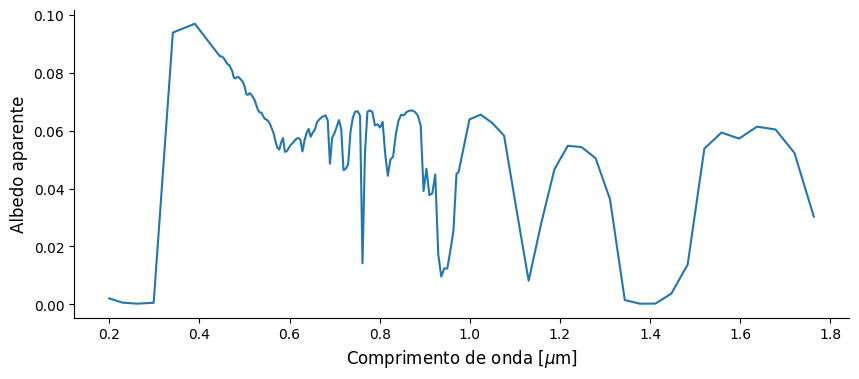

In [12]:
wave_freq = df["Wave/freq"]
total_albedo = df["Total"]

_, ax = plt.subplots()
ax.plot(wave_freq, total_albedo)
ax.set(xlabel="Comprimento de onda [$\mu$m]", ylabel="Albedo aparente");

## Teste 2 - Mudando as abundâncias

In [24]:
def test_abundancias(config, valor, gas):
    mod._gas(config, gas, valor)
    resultado = psg.run(config)

    colunas = ["Wave/freq", "Total", "Noise", "Exoplanet"]
    return pd.DataFrame(resultado["spectrum"], columns=colunas)

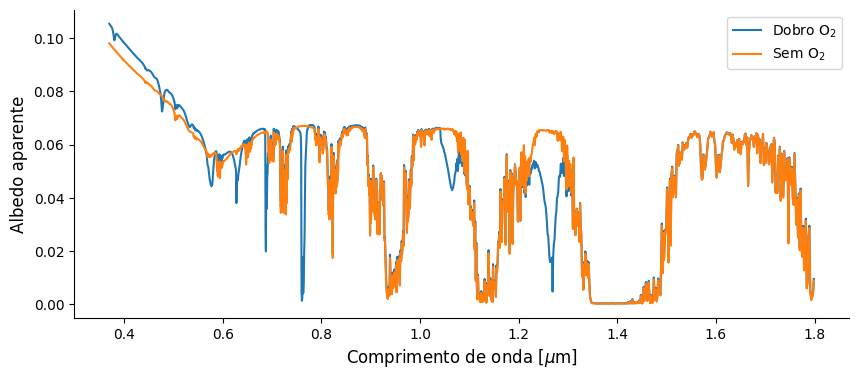

In [26]:
# Dobrando o valor de O2
config_dobro_02 = config_HWC.copy()
df_dobro_O2 = test_abundancias(config_dobro_02, gas="O2", valor=2)

# Tirando O2 da atmosfera
config_zero_02 = config_HWC.copy()
df_sem_O2 = test_abundancias(config_zero_02, gas="O2", valor=0)

_, ax = plt.subplots()
ax.plot(df_dobro_O2["Wave/freq"], df_dobro_O2["Total"], label="Dobro O${}_2$")
ax.plot(df_sem_O2["Wave/freq"], df_sem_O2["Total"], label="Sem O${}_2$")
ax.set(xlabel="Comprimento de onda [$\mu$m]", ylabel="Albedo aparente")
ax.legend();

## Teste 3 - Modificando a pressão atmosférica (mbar)

In [27]:
def test_pressao(config, pressao):
    config["ATMOSPHERE-PRESSURE"] = str(pressao)
    resultado = psg.run(config)

    colunas = ["Wave/freq", "Total", "Noise", "Exoplanet"]
    return pd.DataFrame(resultado["spectrum"], columns=colunas)

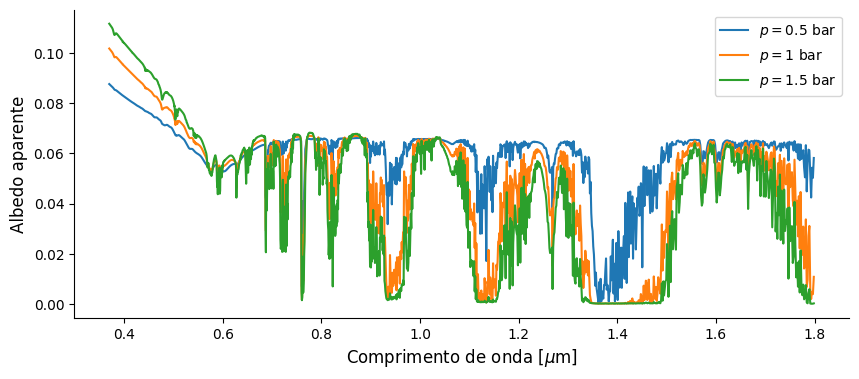

In [30]:
# 500 mbar = .5 bar
# O espectro não retornou nada para o dobro e 4x a pressão atmosférica
config_metade_atm = config_HWC.copy()
df_metade_atm = test_pressao(config_metade_atm, 500)

config_1_0_atm = config_HWC.copy()
df_1_0_atm = test_pressao(config_1_0_atm, 1000)

config_1_5_atm = config_HWC.copy()
df_1_5_atm = test_pressao(config_1_5_atm, 1500)

_, ax = plt.subplots()
ax.plot(df_metade_atm["Wave/freq"], df_metade_atm["Total"], label="$p = 0.5$ bar")
ax.plot(df_1_0_atm["Wave/freq"], df_1_0_atm["Total"], label="$p = 1$ bar")
ax.plot(df_1_5_atm["Wave/freq"], df_1_5_atm["Total"], label="$p = 1.5$ bar")
ax.set(xlabel="Comprimento de onda [$\mu$m]", ylabel="Albedo aparente")
ax.legend();

Quando a pressão atmosférica diminui, é geralmente um indicativo de uma atmosfera mais rarefeita. Em contrapartida, uma pressão atmosférica mais elevada sugere uma atmosfera mais densa e expansiva. A correlação entre a densidade atmosférica e a visibilidade das assinaturas espectrais está intrinsecamente ligada à interação fóton-molécula. Em uma atmosfera densa, as moléculas presentes têm mais oportunidades de interagir com os fótons, resultando em assinaturas espectrais mais pronunciadas. No entanto, quando a atmosfera é mais rarefeita, essas interações diminuem, levando a uma atenuação significativa das assinaturas espectrais.

## Geração de um modelo aleatório

In [27]:
aleatorio = config_HWC.copy()

mod.rnd(aleatorio)
resultado_random = psg.run(aleatorio)

colunas = ["Wave/freq", "Total"]
df_rnd = pd.DataFrame(resultado_random["spectrum"][:, :2], columns=colunas)

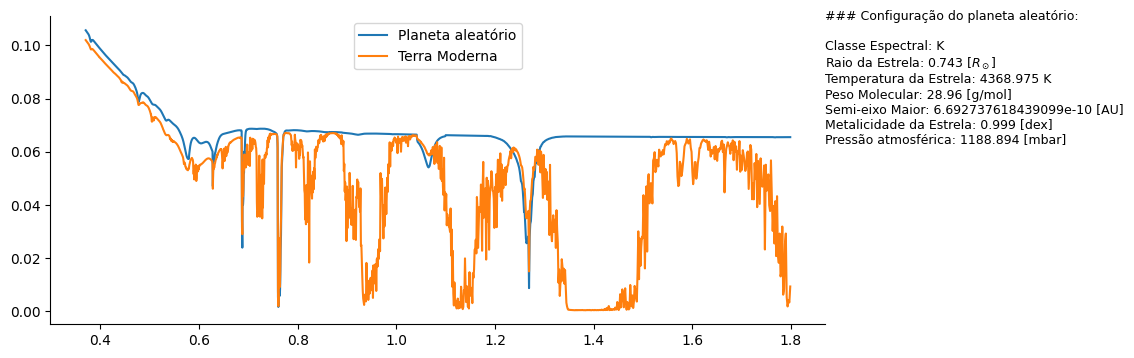

In [28]:
CLASSE_ESPECTRAL = aleatorio['OBJECT-STAR-TYPE']
RAIO_ESTRELA = aleatorio['OBJECT-STAR-RADIUS']
TEMPERATURA_ESTRELA = aleatorio['OBJECT-STAR-TEMPERATURE']
PESO_MOLECULAR = aleatorio['ATMOSPHERE-WEIGHT']
SEMI_EIXO_MAIOR = aleatorio['OBJECT-STAR-DISTANCE']
METALICIDADE_ESTRELA = aleatorio['OBJECT-STAR-METALLICITY']
PRESSAO_ATMO = aleatorio["ATMOSPHERE-PRESSURE"]

_, ax = plt.subplots()

ax.plot(df_rnd["Wave/freq"], df_rnd["Total"], label="Planeta aleatório")
ax.plot(df["Wave/freq"], df["Total"], label="Terra Moderna")
plt.legend(loc = "upper center")

texto = ("### Configuração do planeta aleatório:\n\n"
         f"Classe Espectral: {CLASSE_ESPECTRAL}\n"
         f"Raio da Estrela: {RAIO_ESTRELA} [$R_\odot$]\n"
         f"Temperatura da Estrela: {TEMPERATURA_ESTRELA} K\n"
         f"Peso Molecular: {PESO_MOLECULAR} [g/mol]\n"
         f"Semi-eixo Maior: {SEMI_EIXO_MAIOR} [AU]\n"
         f"Metalicidade da Estrela: {METALICIDADE_ESTRELA} [dex]\n"
         f"Pressão atmosférica: {PRESSAO_ATMO} [mbar]")

plt.text(1, 0.8, texto,
         horizontalalignment='left',
         verticalalignment='center',
         fontsize = 9, transform=plt.gca().transAxes)

plt.show()